# Transfer Learning in TF2 Using Google Images
Sometimes, you want to train an image recognition model, but you don't have that large of a dataset. In such a case, you would use transfer learning with a pretrained convolutional neural network. This is an example of doing just that: a dataset of 265 images of grizzly, black, and teddy bears.  

The model was trained in Tensorflow 2.0 beta, using the MobileNetV2 model with imagenet weights.

### Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
keras = tf.keras
# tf.enable_eager_execution()  # Enables eager execution on a compiled TF2 build

## Data Preprocessing
The data is organized in 3 subfolders, which each folder name representing the class of the images within.

In [2]:
data_root = pathlib.Path('./data/')
for item in data_root.iterdir():
    print(item)

data/grizzly
data/teddys
data/black


Load and shuffle the paths of all the images.

In [3]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths); image_count

269

Create the label names and automatically assign an index to them

In [4]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'black': 0, 'grizzly': 1, 'teddys': 2}

Assign a label to each path based on folder name

In [5]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 1, 2, 2, 0, 0, 0, 2, 2, 2]


Define a function to load the images from the paths, and map it to the existing path dataset. Then, zip the label dataset and image dataset together to create the completed set

In [6]:
def load_img(path):
    image = tf.io.read_file(path)
    return tf.image.decode_jpeg(image, channels=3)

path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_img)
label_ds = tf.data.Dataset.from_tensor_slices(all_image_labels)
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<ZipDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int32)>

Split the dataset into a training, validation, and test set, using the ratio 8:1:1, respectively. 

In [7]:
def split_ds(ds, ds_size, train_percent, val_percent, test_percent):
    train_size = int(train_percent * ds_size)
    val_size = int(val_percent * ds_size)
    test_size = int(test_percent * ds_size)
    
    train = ds.take(train_size)
    temp = ds.skip(train_size)
    validation = temp.skip(test_size)
    test = temp.take(test_size)
    
    return train, validation, test

raw_train, raw_validation, raw_test = split_ds(image_label_ds,
                                               image_count,
                                               .8, .1, .1)

Show a few example images from the training dataset

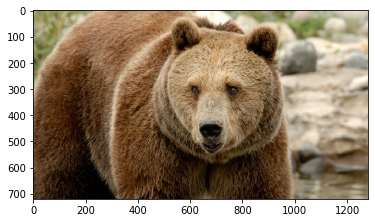

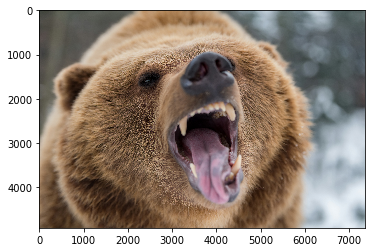

In [8]:
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)

### Format the Data
Format the images to a the same size, then normalize the RGB values to a range of `[-1, 1]`.

In [9]:
IMG_SIZE = 265 # 265 x 265

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Shuffle and batch the data

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [11]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## Create and train the model
Using Google's MobileNetV2, create and freeze the base model with imagenet weights.

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                           include_top=False,
                                           weights='imagenet')
base_model.trainable = False

/home/robbie/.local/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### Add a classification head
Add a `GlobalAveragePooling2D` layer and a `Dense` layer to classify the output from the base model.

In [13]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(3, activation='softmax')

Create the full sequential model

In [14]:
model = keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

### Compile the model
Since there are 3 classes, we are using sparse categorical cross-entropy loss

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 9, 9, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model

In [17]:
initial_epochs = 10

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches) 

Epoch 1/10


W0811 12:29:27.910003 140204827273024 deprecation.py:323] From /home/robbie/anaconda3/envs/ai/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


7/7 [==============================] - 15s 2s/step - loss: 1.1894 - accuracy: 0.2930 - val_loss: 1.1543 - val_accuracy: 0.2857
Epoch 2/10
7/7 [==============================] - 7s 939ms/step - loss: 1.0960 - accuracy: 0.3721 - val_loss: 1.1036 - val_accuracy: 0.4286
Epoch 3/10
7/7 [==============================] - 7s 946ms/step - loss: 1.0327 - accuracy: 0.4372 - val_loss: 1.0584 - val_accuracy: 0.5357
Epoch 4/10
7/7 [==============================] - 7s 960ms/step - loss: 0.9784 - accuracy: 0.5070 - val_loss: 1.0162 - val_accuracy: 0.5357
Epoch 5/10
7/7 [==============================] - 7s 954ms/step - loss: 0.9293 - accuracy: 0.5628 - val_loss: 0.9762 - val_accuracy: 0.5714
Epoch 6/10
7/7 [==============================] - 7s 953ms/step - loss: 0.8839 - accuracy: 0.6093 - val_loss: 0.9380 - val_accuracy: 0.6071
Epoch 7/10
7/7 [==============================] - 7s 944ms/step - loss: 0.8416 - accuracy: 0.6744 - val_loss: 0.9015 - val_accuracy: 0.6071
Epoch 8/10
7/7 [=================

### History curves
Analyze the curves of the training/validation accuracy and loss

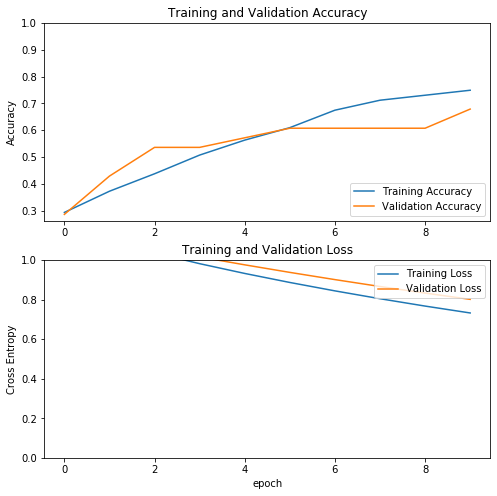

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
Fine-tune the base model after the initial training. This allows for a higher accuracy than what was previously achieved

### Un-freeze the top layers of the model
Unfreeze the `base_model`, then refreeze the bottom layers.

In [19]:
base_model.trainable = True

# Refreeze the bottom 100 layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Compile the model
Using a much lower training rate

In [20]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer = keras.optimizers.RMSprop(lr=base_learning_rate/10),
             metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 9, 9, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,866,435
Non-trainable params: 395,392
_________________________________________________________________


### Continue training

In [22]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                        epochs=total_epochs,
                        initial_epoch=initial_epochs,
                        validation_data=validation_batches)

Epoch 11/20
7/7 [==============================] - 23s 3s/step - loss: 0.6191 - accuracy: 0.8093 - val_loss: 0.6470 - val_accuracy: 0.9643
Epoch 12/20
7/7 [==============================] - 7s 974ms/step - loss: 0.4415 - accuracy: 0.9116 - val_loss: 0.5765 - val_accuracy: 1.0000
Epoch 13/20
7/7 [==============================] - 7s 973ms/step - loss: 0.3535 - accuracy: 0.9628 - val_loss: 0.5220 - val_accuracy: 1.0000
Epoch 14/20
7/7 [==============================] - 7s 977ms/step - loss: 0.2902 - accuracy: 0.9674 - val_loss: 0.4759 - val_accuracy: 1.0000
Epoch 15/20
7/7 [==============================] - 7s 972ms/step - loss: 0.2408 - accuracy: 0.9907 - val_loss: 0.4359 - val_accuracy: 1.0000
Epoch 16/20
7/7 [==============================] - 7s 981ms/step - loss: 0.2009 - accuracy: 0.9907 - val_loss: 0.4002 - val_accuracy: 1.0000
Epoch 17/20
7/7 [==============================] - 7s 974ms/step - loss: 0.1679 - accuracy: 0.9953 - val_loss: 0.3679 - val_accuracy: 1.0000
Epoch 18/20
7/7

Analyze the curves of the training/validation accuracy and loss of the fine-tuned model.

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

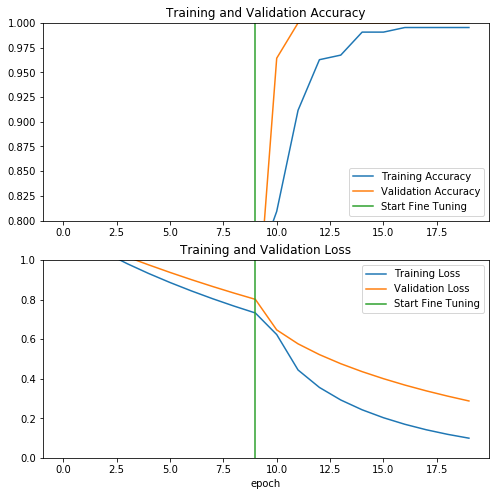

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluate the test dataset to see our final performance!

In [25]:
test_steps = 20
final_loss, final_accuracy = model.evaluate(test_batches, steps=test_steps)

 1/20 [>.............................] - ETA: 1:12 - loss: 0.2697 - accuracy: 1.0000

W0811 12:32:07.990820 140204827273024 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


In [26]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}".format(final_accuracy))

Final loss: 0.01
Final accuracy: 1.00


In [27]:
model.save('bears_fine')